In [1]:
!pip install numpy==1.25.0 
!pip install --upgrade catboost --no-deps  

In [2]:
!pip install scikit-optimize

In [3]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from skopt import BayesSearchCV
import shap

In [9]:
# Import Required Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)  # Show all columns

# Load Dataset
df = pd.read_csv(r'C:\Users\Shash\OneDrive\Desktop\churn\data\WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Display initial data info
print("🔍 Initial Dataset Overview:")
print(df.info())




🔍 Initial Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilli

In [10]:
# Display first few rows
df.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   
1              Yes          No          No              No        One year   
2               No          No          No              No  Month-to-month   
3              Yes         Yes          No              No        One year   
4               No          No          No              No  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  \
0              Yes           Electronic check           29.85        29.85   
1               No               Mailed check           56.95       1889.5   
2              Yes               Mailed check           53.85       108.15   
3               No  Bank transfer (automatic)           42.30      1840.75   
4              Yes           Electronic check           70.70       151.65   

  Churn  
0    No  
1    No  
2   Yes  
3    No  
4   Yes

In [11]:
# Filtering out rows with non-numerical values in 'TotalCharges' column:

non_numeric_rows= df[pd.to_numeric(df['TotalCharges'],errors='coerce').isna()]
non_numeric_rows

customerID  gender  SeniorCitizen Partner Dependents  tenure  \
488   4472-LVYGI  Female              0     Yes        Yes       0   
753   3115-CZMZD    Male              0      No        Yes       0   
936   5709-LVOEQ  Female              0     Yes        Yes       0   
1082  4367-NUYAO    Male              0     Yes        Yes       0   
1340  1371-DWPAZ  Female              0     Yes        Yes       0   
3331  7644-OMVMY    Male              0     Yes        Yes       0   
3826  3213-VVOLG    Male              0     Yes        Yes       0   
4380  2520-SGTTA  Female              0     Yes        Yes       0   
5218  2923-ARZLG    Male              0     Yes        Yes       0   
6670  4075-WKNIU  Female              0     Yes        Yes       0   
6754  2775-SEFEE    Male              0      No        Yes       0   

     PhoneService     MultipleLines InternetService       OnlineSecurity  \
488            No  No phone service             DSL                  Yes   
753           Yes                No              No  No internet service   
936           Yes                No             DSL                  Yes   
1082          Yes               Yes              No  No internet service   
1340           No  No phone service             DSL                  Yes   
3331          Yes                No              No  No internet service   
3826          Yes               Yes              No  No internet service   
4380          Yes                No              No  No internet service   
5218          Yes                No              No  No internet service   
6670          Yes               Yes             DSL                   No   
6754          Yes               Yes             DSL                  Yes   

             OnlineBackup     DeviceProtection          TechSupport  \
488                    No                  Yes                  Yes   
753   No internet service  No internet service  No internet service   
936                   Yes                  Yes                   No   
1082  No internet service  No internet service  No internet service   
1340                  Yes                  Yes                  Yes   
3331  No internet service  No internet service  No internet service   
3826  No internet service  No internet service  No internet service   
4380  No internet service  No internet service  No internet service   
5218  No internet service  No internet service  No internet service   
6670                  Yes                  Yes                  Yes   
6754                  Yes                   No                  Yes   

              StreamingTV      StreamingMovies  Contract PaperlessBilling  \
488                   Yes                   No  Two year              Yes   
753   No internet service  No internet service  Two year               No   
936                   Yes                  Yes  Two year               No   
1082  No internet service  No internet service  Two year               No   
1340                  Yes                   No  Two year               No   
3331  No internet service  No internet service  Two year               No   
3826  No internet service  No internet service  Two year               No   
4380  No internet service  No internet service  Two year               No   
5218  No internet service  No internet service  One year              Yes   
6670                  Yes                   No  Two year               No   
6754                   No                   No  Two year              Yes   

                  PaymentMethod  MonthlyCharges TotalCharges Churn  
488   Bank transfer (automatic)           52.55                 No  
753                Mailed check           20.25                 No  
936                Mailed check           80.85                 No  
1082               Mailed check           25.75                 No  
1340    Credit card (automatic)           56.05                 No  
3331               Mailed check           19.85             

In [12]:
# Replacing the blank values in TotalCharges column:

df.loc[df['TotalCharges']==" ", 'TotalCharges']=  df.loc[df['TotalCharges']==" ", 'MonthlyCharges']

In [13]:
# Converting TotalCharges into float data type:
df['TotalCharges'] = df['TotalCharges'].astype('float')

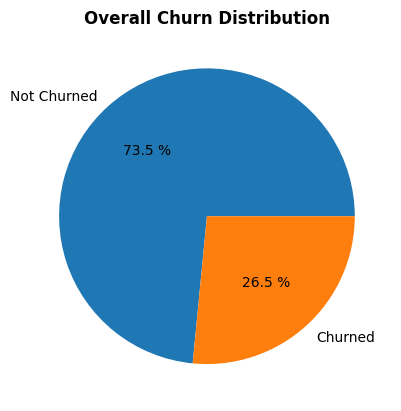

In [14]:
# Creating a pie chart for overall churn distribution:

churncounts=df['Churn'].value_counts()
plt.pie(churncounts, autopct='%1.1f %%',labels= ['Not Churned','Churned'])
plt.title("Overall Churn Distribution",fontweight='bold')
plt.show()

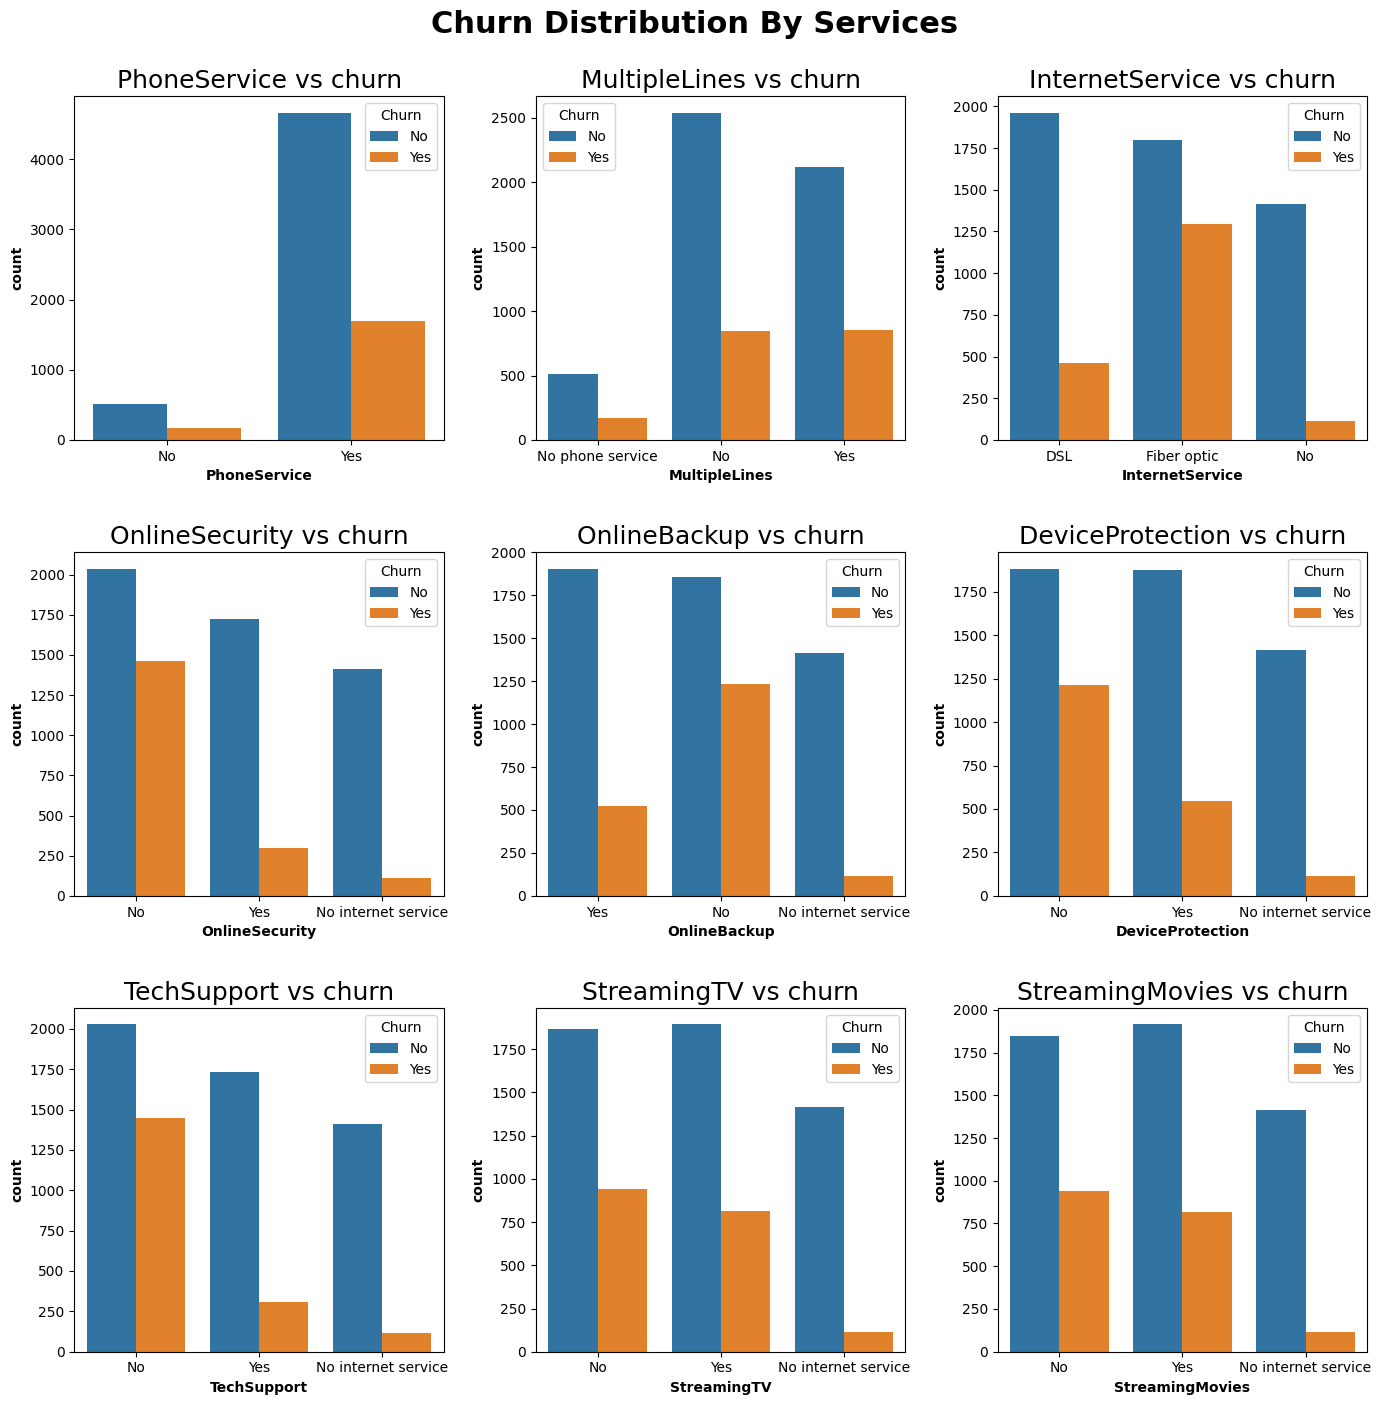

In [15]:
# Creating subplots for the distribution or churn by each service:

fig,axes= plt.subplots(3,3, figsize=(14,14))
axes= axes.flatten()

service_cols= ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']

for i, service in enumerate(service_cols):
    sns.countplot(data=df,x=service, hue='Churn',ax=axes[i])
    axes[i].set_title(f"{service} vs churn", fontsize= 18)
    axes[i].set_xlabel(service, fontweight='bold')
    axes[i].set_ylabel("count", fontweight='bold')


plt.suptitle("Churn Distribution By Services", fontsize=22, fontweight='bold', y=1)
plt.tight_layout(h_pad=3)
plt.show()

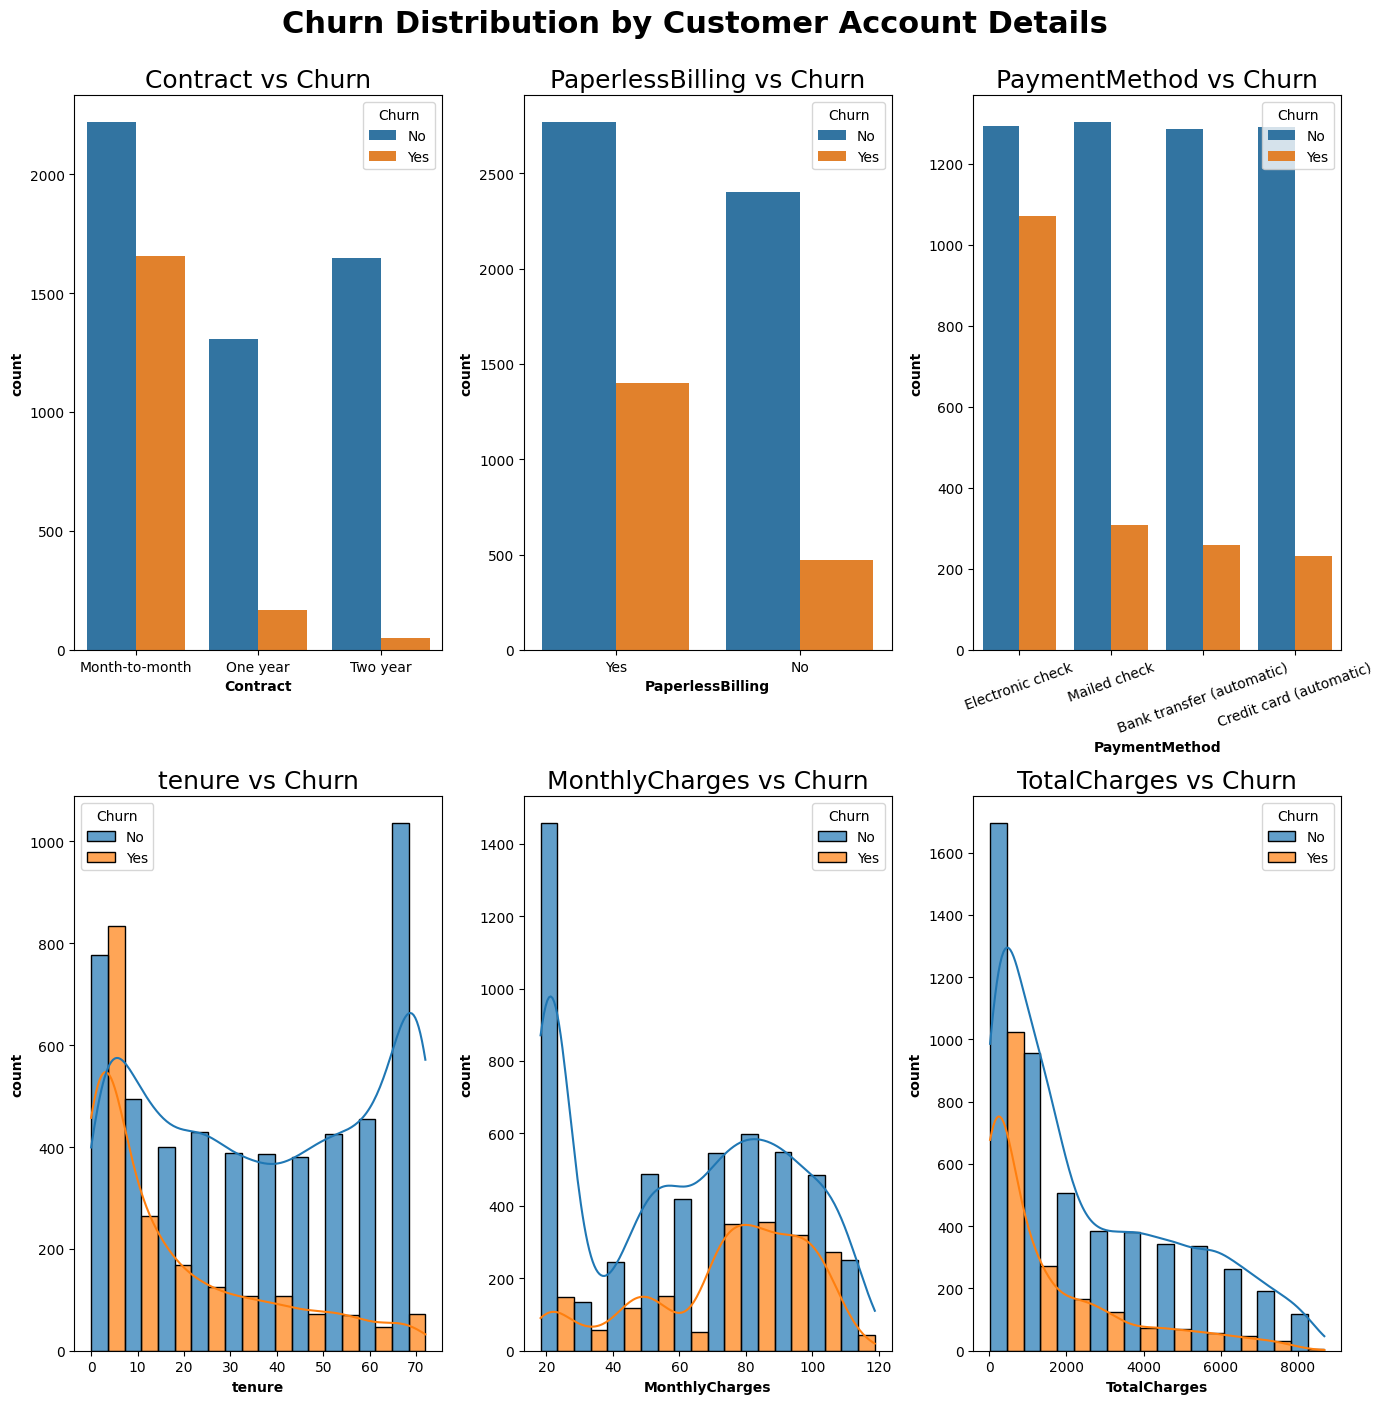

In [16]:
# Creating subplots for distribution of chrun by customer account details:

fig,axes= plt.subplots(2,3, figsize=(14,14))
axes= axes.flatten()

# plotting for non_numerical columns:
non_numerical_cols= ['Contract', 'PaperlessBilling','PaymentMethod']
for i,col in enumerate(non_numerical_cols):
    sns.countplot(data=df, x=col, hue='Churn', ax=axes[i])
    axes[i].set_title(f"{col} vs Churn",fontsize=18)
    if col=='PaymentMethod':
        axes[i].tick_params(axis='x',rotation=20)
    axes[i].set_xlabel(col, fontweight='bold')
    axes[i].set_ylabel("count", fontweight='bold')

# plotting for numerical columns:
numerical_cols= ['tenure', 'MonthlyCharges', 'TotalCharges']
for i,col in enumerate(numerical_cols):
    sns.histplot(data=df, x=col, hue='Churn',ax=axes[i+3],multiple='dodge',kde=True,bins=10, alpha=0.7)
    axes[i+3].set_title(f"{col} vs Churn",fontsize=18)
    axes[i+3].set_xlabel(col, fontweight='bold')
    axes[i+3].set_ylabel("count", fontweight='bold')


plt.suptitle("Churn Distribution by Customer Account Details",fontsize=22, fontweight='bold', y=1)
plt.tight_layout()
plt.show()

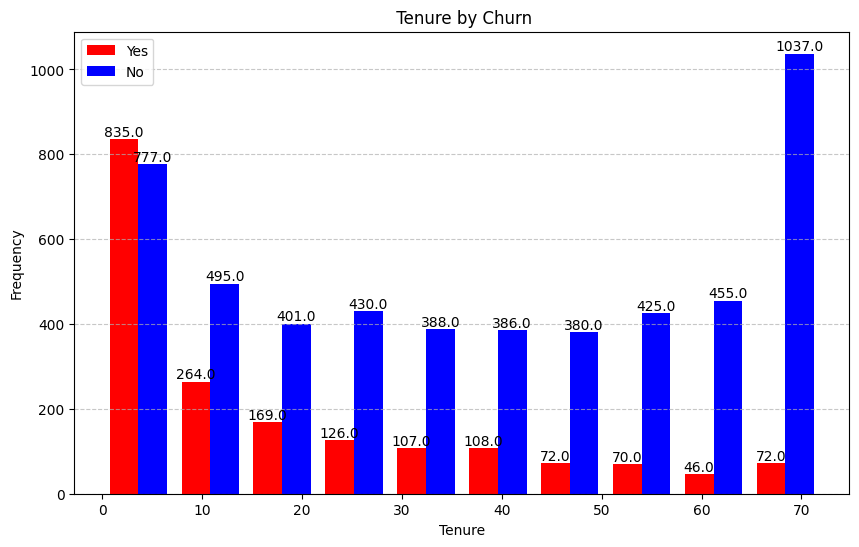

In [17]:
churned = df[df['Churn'] == 'Yes']
not_churned = df[df['Churn'] == 'No']

# Plotting
plt.figure(figsize=(10, 6))
plt.hist([churned['tenure'], not_churned['tenure']], bins=10, color=['red', 'blue'], label=['Yes', 'No'])
plt.title(' Tenure by Churn')
plt.xlabel('Tenure')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Add text on top of bars
for rect in plt.gca().patches:
    height = rect.get_height()
    plt.gca().text(rect.get_x() + rect.get_width() / 2, height, height, ha='center', va='bottom')

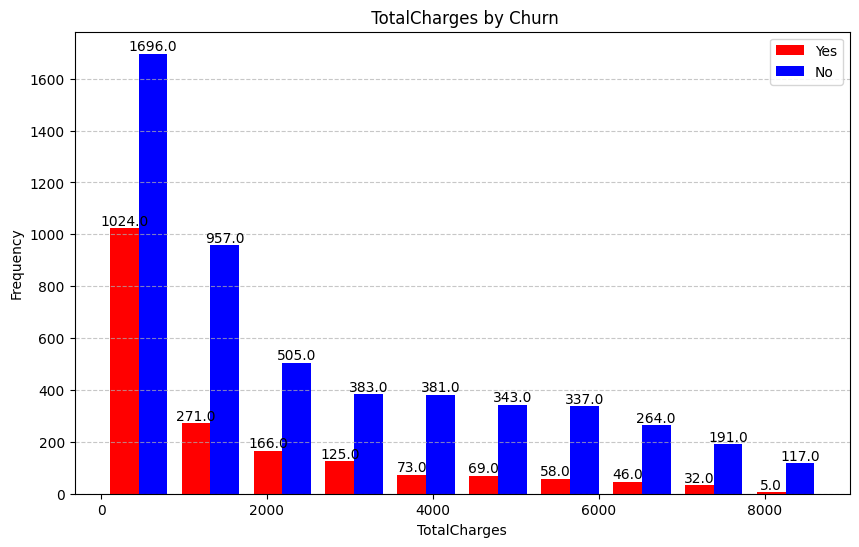

In [18]:
churned = df[df['Churn'] == 'Yes']
not_churned = df[df['Churn'] == 'No']

# Plotting
plt.figure(figsize=(10, 6))
plt.hist([churned['TotalCharges'], not_churned['TotalCharges']], bins=10, color=['red', 'blue'], label=['Yes', 'No'])
plt.title(' TotalCharges by Churn')
plt.xlabel('TotalCharges')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Add text on top of bars
for rect in plt.gca().patches:
    height = rect.get_height()
    plt.gca().text(rect.get_x() + rect.get_width() / 2, height, height, ha='center', va='bottom')

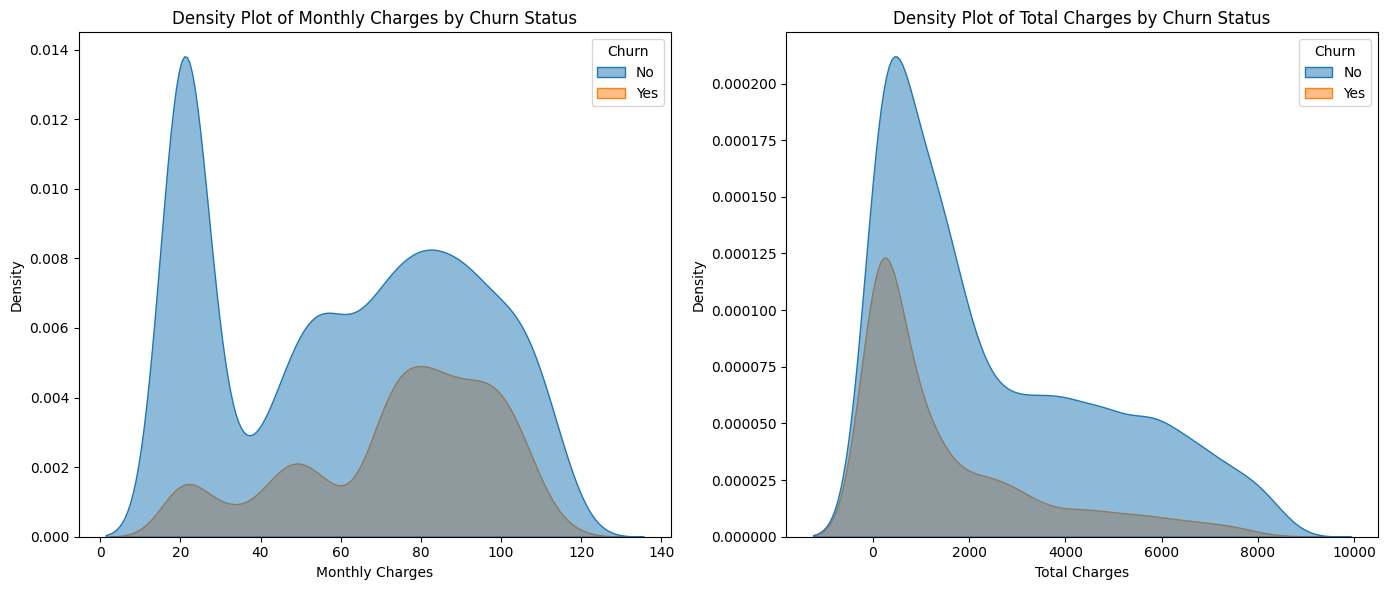

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for Monthly Charges
sns.kdeplot(data=df, x="MonthlyCharges", hue="Churn", fill=True, alpha=0.5, ax=axes[0])
axes[0].set_title('Density Plot of Monthly Charges by Churn Status')
axes[0].set_xlabel('Monthly Charges')
axes[0].set_ylabel('Density')

# Plot for Total Charges
sns.kdeplot(data=df, x="TotalCharges", hue="Churn", fill=True, alpha=0.5, ax=axes[1])
axes[1].set_title('Density Plot of Total Charges by Churn Status')
axes[1].set_xlabel('Total Charges')
axes[1].set_ylabel('Density')

plt.tight_layout()
plt.show()

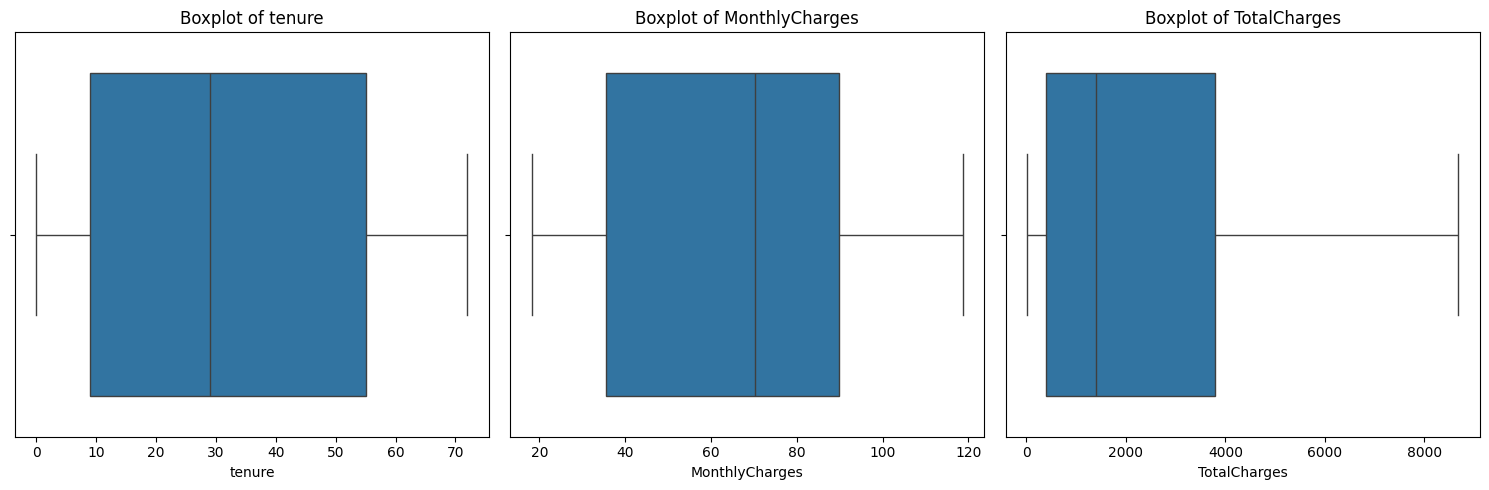

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert 'TotalCharges' to numeric, coercing errors to NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# List of numeric columns to check for outliers
numeric_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Plot boxplots to detect outliers
plt.figure(figsize=(15, 5))
for idx, column in enumerate(numeric_columns, 1):
    plt.subplot(1, len(numeric_columns), idx)
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()


In [21]:
df.drop('customerID', axis=1, inplace=True)

In [22]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

In [23]:
# Feature Engineering
df['MonthlyTenureRatio'] = df['MonthlyCharges'] / (df['tenure'] + 1)
df['TotalTenureRatio'] = df['TotalCharges'] / (df['tenure'] + 1)
df['IsLongTermCustomer'] = (df['tenure'] > 24).astype(int)
df['HighValueCustomer'] = (df['TotalCharges'] > df['TotalCharges'].quantile(0.75)).astype(int)
df['IsTechServiceUser'] = ((df['TechSupport'] == 1) | (df['OnlineSecurity'] == 1)).astype(int)
df['FiberOpticDissatisfaction'] = ((df['InternetService'] == 1) & (df['Churn'] == 1)).astype(int)

In [24]:
# Separate features and target
X = df.drop('Churn', axis=1)
y = df['Churn']


In [25]:
# Define Ant Colony Optimization for Feature Selection
class ACOFeatureSelector:
    def __init__(self, n_ants, n_iterations, evaporation_rate, Q):
        self.n_ants = n_ants
        self.n_iterations = n_iterations
        self.evaporation_rate = evaporation_rate
        self.Q = Q

    def fit(self, X, y):
        n_features = X.shape[1]
        pheromones = np.ones(n_features)
        best_score = 0
        best_features = None

        for iteration in range(self.n_iterations):
            solutions, scores = [], []

            for ant in range(self.n_ants):
                features_mask = self.select_features(pheromones)
                if features_mask.sum() == 0:
                    features_mask[np.random.randint(0, n_features)] = True

                score = self.evaluate_solution(X, y, features_mask)
                solutions.append(features_mask)
                scores.append(score)

                if score > best_score:
                    best_score = score
                    best_features = features_mask.copy()

            self.update_pheromones(pheromones, solutions, scores)

        self.best_features_ = best_features
        return self

    def select_features(self, pheromones):
        probabilities = pheromones / pheromones.sum()
        return np.random.rand(len(pheromones)) < probabilities

    def evaluate_solution(self, X, y, mask):
        clf = RandomForestClassifier(n_estimators=100, random_state=42)
        scores = cross_val_score(clf, X[:, mask], y, cv=5, scoring='accuracy')
        return scores.mean()

    def update_pheromones(self, pheromones, solutions, scores):
        pheromones *= (1 - self.evaporation_rate)
        for solution, score in zip(solutions, scores):
            pheromones[solution] += self.Q * score

## ANT COLONY OPTIMISATION 
Ant Colony Optimization (ACO) is a metaheuristic algorithm inspired by nature, which proves to be highly effective in predicting customer churn in the telecommunications sector, especially in the area of feature selection. In churn analysis, the primary objective is to determine the likelihood of a customer discontinuing their service with a telecom provider. ACO plays a vital role in pinpointing the most pertinent features from a large and intricate dataset. This is essential, as telecom datasets typically encompass a wide array of variables, including customer demographics, usage behaviors, billing details, and service-related complaints. ACO emulates the foraging behavior of ants, where artificial agents (referred to as ants) investigate different feature combinations and share their discoveries through a virtual pheromone trail. With each iteration, features that enhance model performance receive increased pheromone reinforcement, steering the search towards optimal or near-optimal subsets of features. By combining ACO with classifiers such as Random Forest, XGBoost, or CatBoost, the model can be trained on these chosen features, leading to improved prediction accuracy, minimized overfitting, and enhanced computational efficiency. Ultimately, the application of ACO in telecom churn prediction allows data scientists to develop more robust and interpretable models, assisting telecom companies in proactively retaining customers who are at risk of leaving.

In [26]:
# ACO Feature Selection
aco_selector = ACOFeatureSelector(n_ants=10, n_iterations=20, evaporation_rate=0.1, Q=0.1)
aco_selector.fit(X.values, y.values)
selected_features = X.columns[aco_selector.best_features_]
print("ACO Selected Features:", selected_features)

ACO Selected Features: Index(['SeniorCitizen', 'StreamingMovies', 'FiberOpticDissatisfaction'], dtype='object')


In [27]:
# Scale selected features
scaler = StandardScaler()
X_selected = scaler.fit_transform(X[selected_features])

In [28]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [29]:
# SMOTE for imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [30]:
# Initialize and train models
lgbm = LGBMClassifier(n_estimators=500, learning_rate=0.05, max_depth=7, random_state=42)
xgb = XGBClassifier(n_estimators=500, learning_rate=0.05, max_depth=7, use_label_encoder=False, eval_metric="logloss", random_state=42)
cat = CatBoostClassifier(iterations=500, learning_rate=0.05, depth=7, verbose=0, random_state=42)

lgbm.fit(X_resampled, y_resampled)
xgb.fit(X_resampled, y_resampled)
cat.fit(X_resampled, y_resampled)

  File "c:\Users\Shash\AppData\Local\Programs\Python\Python39\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\Shash\AppData\Local\Programs\Python\Python39\lib\subprocess.py", line 505, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\Shash\AppData\Local\Programs\Python\Python39\lib\subprocess.py", line 951, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\Shash\AppData\Local\Programs\Python\Python39\lib\subprocess.py", line 1420, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


[LightGBM] [Info] Number of positive: 4138, number of negative: 4138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000793 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10
[LightGBM] [Info] Number of data points in the train set: 8276, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 


✅ LightGBM Performance:
📌 Accuracy: 0.9241
📌 F1 Score: 0.8326
📌 AUC-ROC: 0.8566


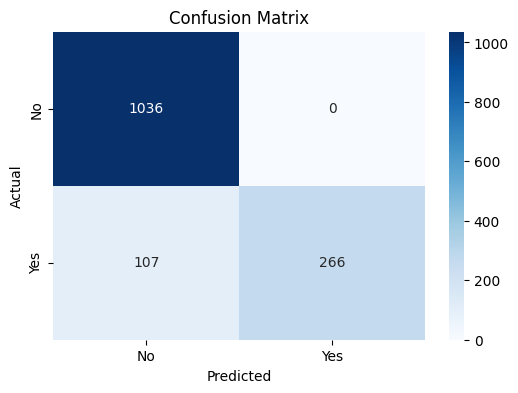


📝 Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1036
           1       1.00      0.71      0.83       373

    accuracy                           0.92      1409
   macro avg       0.95      0.86      0.89      1409
weighted avg       0.93      0.92      0.92      1409


✅ XGBoost Performance:
📌 Accuracy: 0.9241
📌 F1 Score: 0.8326
📌 AUC-ROC: 0.8566


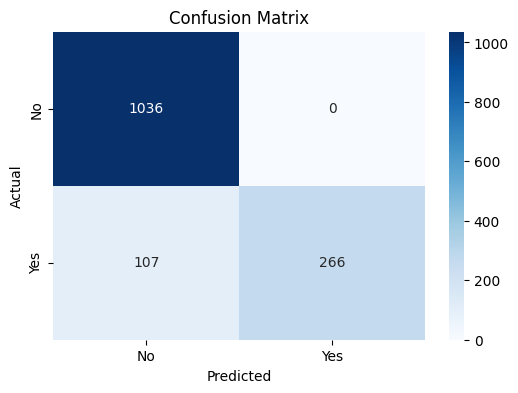


📝 Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1036
           1       1.00      0.71      0.83       373

    accuracy                           0.92      1409
   macro avg       0.95      0.86      0.89      1409
weighted avg       0.93      0.92      0.92      1409


✅ CatBoost Performance:
📌 Accuracy: 0.9241
📌 F1 Score: 0.8326
📌 AUC-ROC: 0.8566


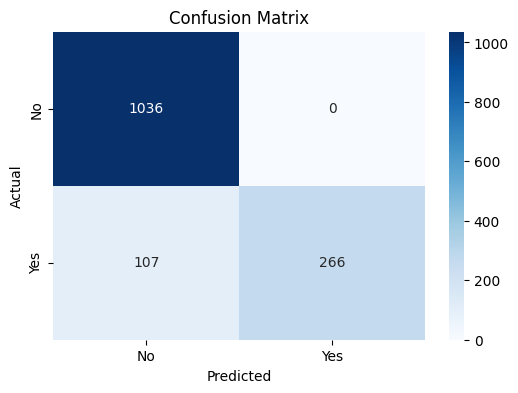


📝 Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1036
           1       1.00      0.71      0.83       373

    accuracy                           0.92      1409
   macro avg       0.95      0.86      0.89      1409
weighted avg       0.93      0.92      0.92      1409



In [31]:
# Model evaluation function
def evaluate_model(model_name, y_true, y_pred):
    print(f"\n✅ {model_name} Performance:")
    print(f"📌 Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"📌 F1 Score: {f1_score(y_true, y_pred):.4f}")
    print(f"📌 AUC-ROC: {roc_auc_score(y_true, y_pred):.4f}")

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification Report
    print("\n📝 Classification Report:")
    print(classification_report(y_true, y_pred))
    # Individual model predictions
evaluate_model("LightGBM", y_test, lgbm.predict(X_test))
evaluate_model("XGBoost", y_test, xgb.predict(X_test))
evaluate_model("CatBoost", y_test, cat.predict(X_test))

[LightGBM] [Info] Number of positive: 4138, number of negative: 4138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10
[LightGBM] [Info] Number of data points in the train set: 8276, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

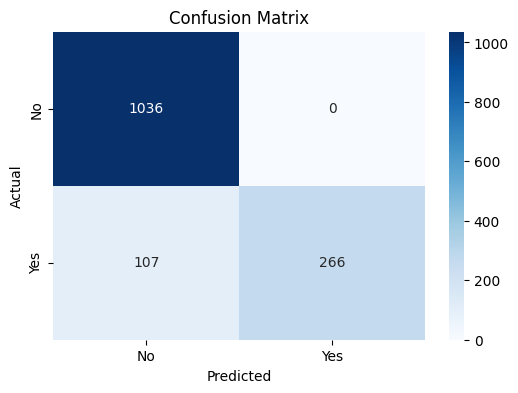


📝 Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1036
           1       1.00      0.71      0.83       373

    accuracy                           0.92      1409
   macro avg       0.95      0.86      0.89      1409
weighted avg       0.93      0.92      0.92      1409



In [32]:
# Stacking Ensemble
stacked_model = StackingClassifier(
    estimators=[('lgb', lgbm), ('xgb', xgb), ('cat', cat)],
    final_estimator=LogisticRegression(),
    cv=5
)
stacked_model.fit(X_resampled, y_resampled)
evaluate_model("Stacking Ensemble", y_test, stacked_model.predict(X_test))

[LightGBM] [Info] Number of positive: 4138, number of negative: 4138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10
[LightGBM] [Info] Number of data points in the train set: 8276, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

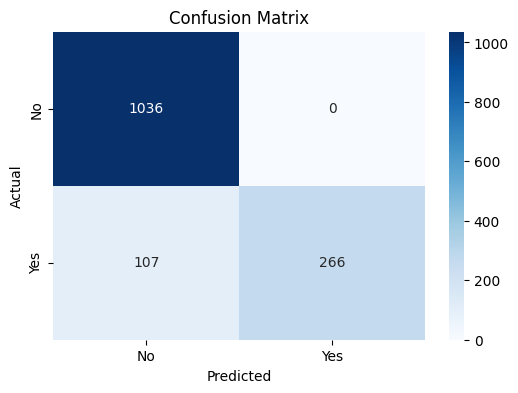


📝 Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1036
           1       1.00      0.71      0.83       373

    accuracy                           0.92      1409
   macro avg       0.95      0.86      0.89      1409
weighted avg       0.93      0.92      0.92      1409



In [33]:
# Hyperparameter Tuning with Bayesian Optimization
param_grid = {'n_estimators': (100, 500), 'learning_rate': (0.01, 0.1, 'log-uniform'), 'max_depth': (3, 10)}
bayes_search = BayesSearchCV(LGBMClassifier(), param_grid, n_iter=30, cv=5, scoring='roc_auc', n_jobs=-1)
bayes_search.fit(X_resampled, y_resampled)

optimized_model = bayes_search.best_estimator_
optimized_model.fit(X_resampled, y_resampled)
evaluate_model("Optimized LightGBM", y_test, optimized_model.predict(X_test))

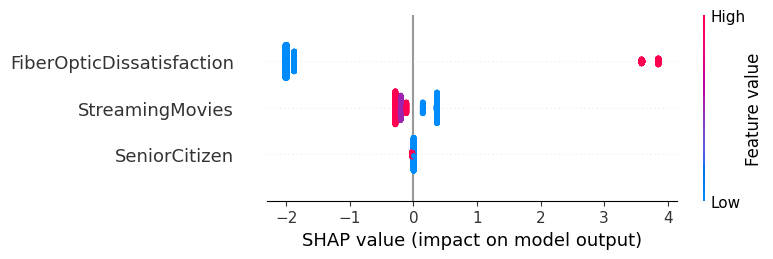

In [34]:
# SHAP Explainability
explainer = shap.Explainer(optimized_model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, feature_names=selected_features)